In [302]:
using PyPlot
using JuMP, Ipopt

In [303]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

### Replicating Belaia configuration

In [301]:
dt = 1. # year timestep
t = Array(2020:dt:2250);

physics = Physics(3.0); # default physics

GWP0 = 100. # global world product (trillion $ / year)

β = 0.02*GWP0/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = -0.005 # ρ

# Control technology cost scales, as fraction of GWP (cost scale is for full deployment, α=1.)
mitigate_cost = 300. * 60.e9 / 1.e12 # Costs from Figure 1 https://arxiv.org/abs/1903.02043
remove_cost = 0.05*GWP0;
geoeng_cost = β*(5.0^2);
adapt_cost = 0.03*GWP0;

# Based on baseline emissions in Figure 4 https://arxiv.org/abs/1903.02043
baseline_emissions_scenario = (
    GtCO2_to_ppm(80.) .- GtCO2_to_ppm(40.) * ( (t .- 2125.) ./ 125.).^2
)

economics = Economics(
    β, utility_discount_rate,
    mitigate_cost, remove_cost, geoeng_cost, adapt_cost,
    0.03, 0., 0., nothing, # Assumed initial condition of zero control deployments in 2020
    baseline_emissions_scenario
);

name = "Belaia";
present_year = 2020.

# Arbitrary initial guess of climate control policies, to be optimized later!
controls = init_zero_controls(t);

# Create instance of idealized integrated assessment climate model
model = ClimateModel(name, t, dt, present_year, economics, physics, controls,);

In [300]:
300. * 80.e9 / 1.e12

24.0

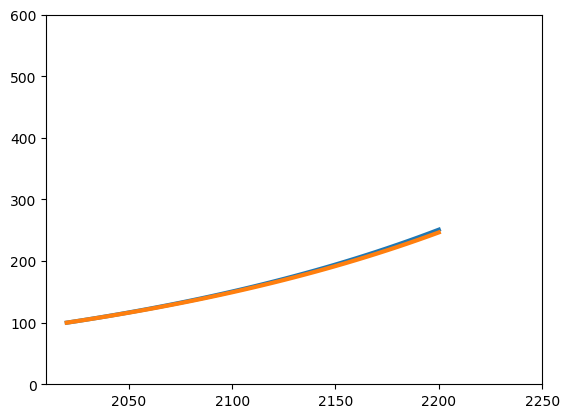

(2010, 2250)

In [291]:
GWP = GWP0 * exp.((t .- t[1]) / 50.)
plot(t, GWP .* (1. + 0.015).^(-t .+ t[1]))
plot(t, GWP0 .* (1. - 0.005).^(-t .+ t[1]))
ylim([0, 600])
xlim([2010, 2250])

In [292]:
optimize_controls!(
    model,
    obj_option = "net_benefit",
    max_deployment=Dict("remove"=>0., "mitigate"=>2., "geoeng"=>0., "adapt"=>0.),
    start_deployment=Dict("remove"=>2020., "mitigate"=>2020., "geoeng"=>2020., "adapt"=>2020.),
    cost_exponent=2.8
);

### Plotting the optimal solution state

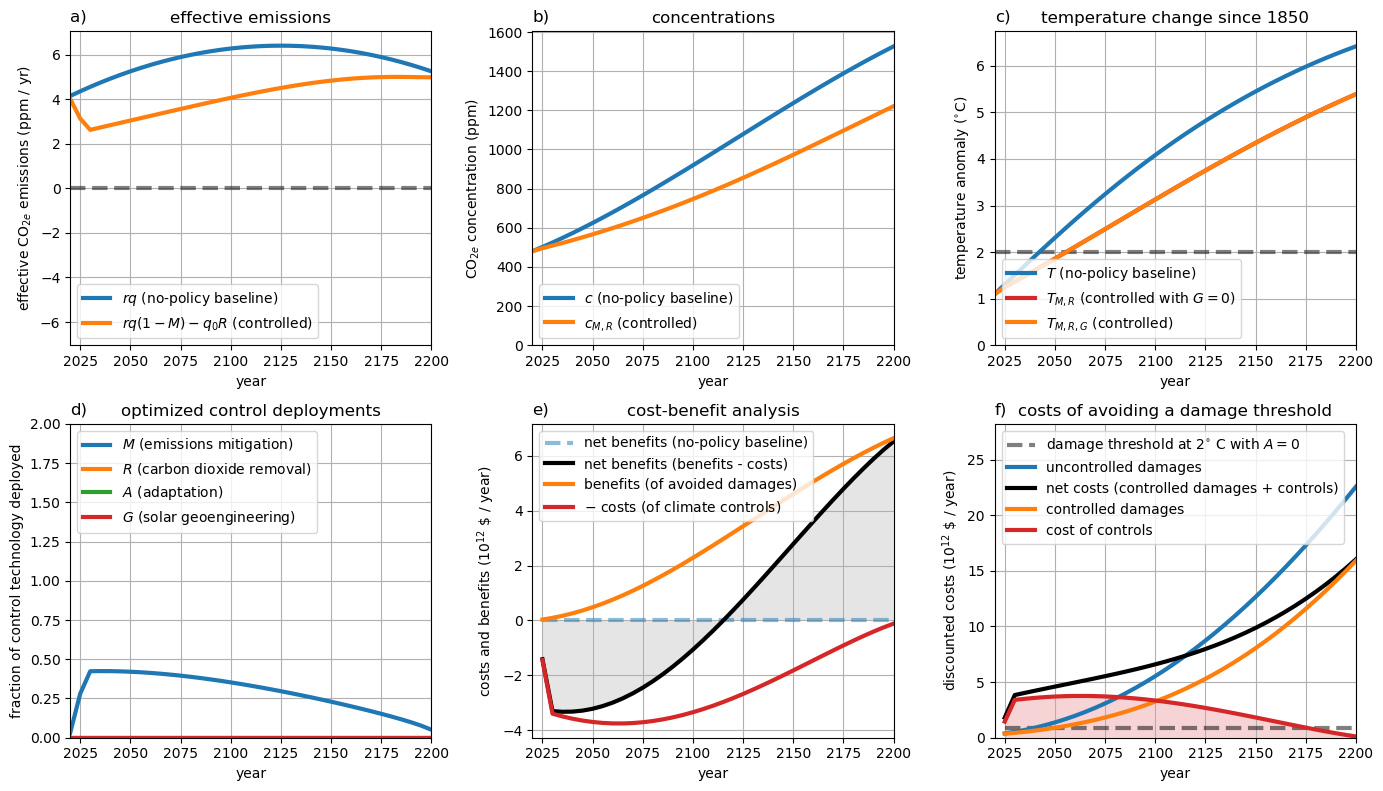

In [293]:
plot_state(model)
subplot(2,3,4)
ylim([0,2])

savefig("../figures/replicate_belaia.png", bbox_inches="tight", dpi=100)

In [272]:
model.controls.mitigate .+= 0.1;

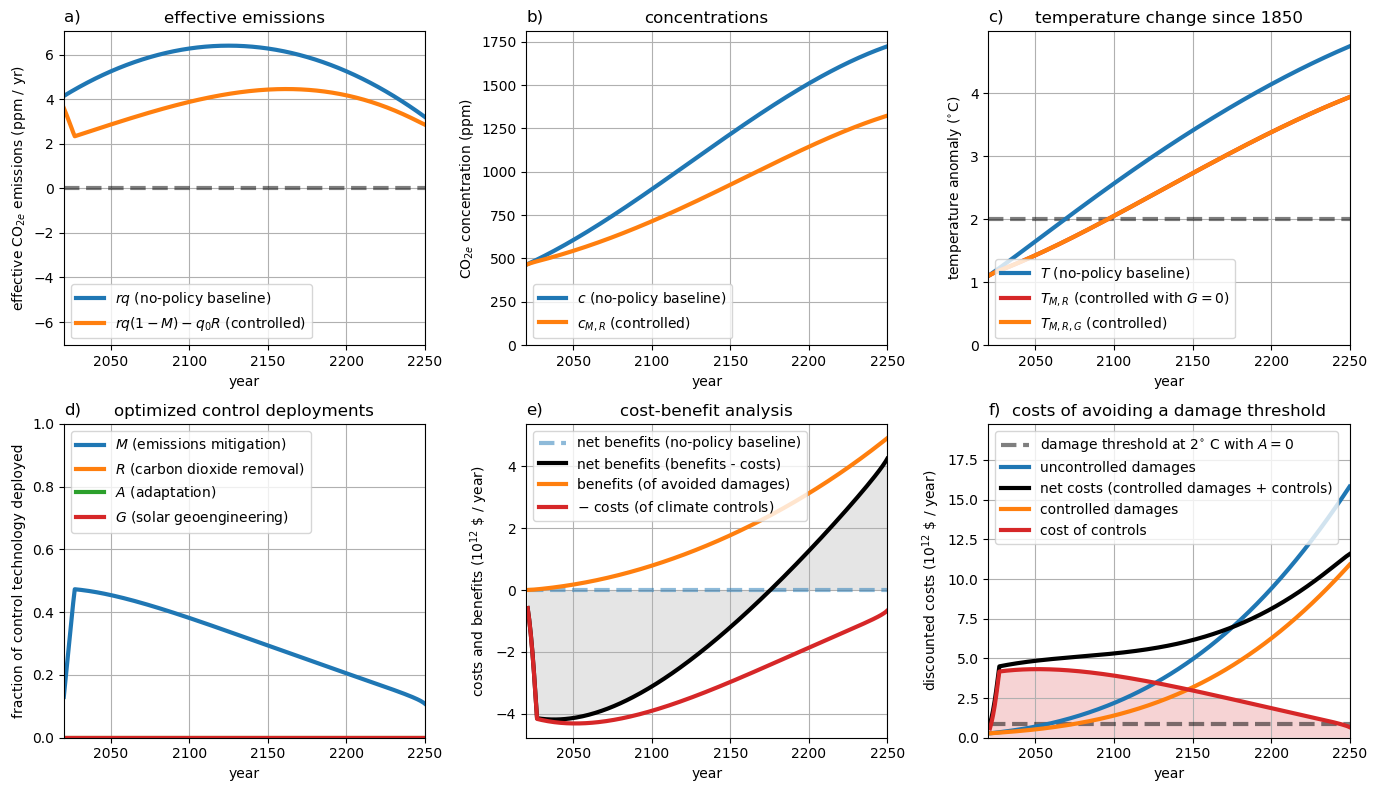

In [273]:
plot_state(model)

In [ ]:
400*